In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes
from skimage.filters import median


In [2]:
def segment_coins(image):
    plt.imshow(image, cmap='gray')
    plt.title('0) Original Image')
    plt.axis('off')
    plt.show()
    
    # Make a copy to avoid modifying the original image.
    img = image.copy()

    # Median filter the intensity row wise to line artifacts.
    row = image[0, :]
    row_median = median(row, np.ones(7))
    for idx in range(1, image.shape[0]):
        row_filtered = median(image[idx, :], np.ones(10))
        img[idx, :] = row_filtered
    
        
    plt.imshow(image, cmap='gray')
    plt.title('1) Row Wise Median Filtered Image')
    plt.axis('off')
    plt.show()

    # Apply adaptive thresholding to get a binary image.
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 1)
    
    plt.imshow(thresh, cmap='gray')
    plt.title('1) Apply Adaptive Thresholding')
    plt.axis('off')
    plt.show()
    
    # Applying morphological closing to connect the background.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    plt.imshow(closing, cmap='gray')
    plt.title('2a) Apply Morphological Closing to Connect Background')
    plt.axis('off')
    plt.show()
    
    # Get the canny edges of the original image to subtract from the closing.
    edges = cv2.Canny(img, 100, 200)
    
    plt.imshow(edges, cmap='gray')
    plt.title('2b) Get Canny Edges over Original Image')
    plt.axis('off')
    plt.show()
    
    # Subtract the edges from the closing to disconnect the background from the coins.
    coins = closing - edges
    
    plt.imshow(coins, cmap='gray')
    plt.title('3) Take Difference Between Closing and Edges to Disconnect Background and Coins')
    plt.axis('off')
    plt.show()
    
    # Morphological opening to ensure background and foreground are fully disconnected.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    opening = cv2.morphologyEx(coins, cv2.MORPH_OPEN, kernel)
    
    plt.imshow(opening, cmap='gray')
    plt.title('4) Morphological Opening to Fully Disconnect Background and Coins')
    plt.axis('off')
    plt.show()
    
    # Find connected components.
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(opening, connectivity=8)
    
    # If there are any components, find the largest by area (including the background).
    if num_labels > 1:
        largest_component = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # Adding 1 because we exclude the background
        largest_mask = labels == largest_component
        
        # Set the largest component to zero (remove it).
        closing[largest_mask] = 0 

    plt.imshow(closing, cmap='gray')
    plt.title('5) Removing Background by Removing Largest Connected Component')
    plt.axis('off')
    plt.show()
    
    # Create a dictionary where key is a region and value is number of pixels in that region.
    labels = label(closing)
    regions = regionprops(labels)
    region_dict = {region.label: region.area for region in regions}
    
    # View histogram of region sizes.
    plt.hist(region_dict.values(), bins=100)
    plt.xlabel('Region Size')
    plt.ylabel('Frequency')
    plt.title('Histogram of Region Sizes')
    plt.yscale('log')
    plt.show()
    
    # Remove all regions with less than 100 pixels, found by looking at the histogram.
    for region in regions:
        if region.area < 100:
            labels[labels == region.label] = 0
            
    # Visualise the result after removing small regions.
    plt.imshow(labels, cmap='nipy_spectral')
    plt.title('6) Remove Small Regions')
    plt.axis('off')
    plt.show()
    
    # Use a final binary fill holes operation to fill any holes.
    filled = label(binary_fill_holes(labels))
    
    plt.imshow(filled, cmap='nipy_spectral')
    plt.title('7) Apply Binary Fill Holes')
    plt.axis('off')
    plt.show()
    
    return filled

In [3]:
def select_coin_segs(labels):
    # Get the region properties of the labels.
    props = regionprops(labels)
    
    # Get a list of centroid coordinates.
    centroids_i = np.array([region.centroid[0] for region in props])
    centroids_j = np.array([region.centroid[1] for region in props])

    # Find centroid bins that have 6 elements in the x direction and 4 elements in the y direction.
    i_bins = [0]
    j_bins = [0]
    
    for i in range(0, labels.shape[0], 10):
        l_bin = i_bins[-1]
        r_bin = i
        
        # Count number of elements in the current bin
        count = centroids_i[(centroids_i >= l_bin) & (centroids_i < r_bin)].shape[0]
        
        if count == 6:
            i_bins.append(r_bin)
    
    for j in range(0, labels.shape[1], 10):
        l_bin = j_bins[-1]
        r_bin = j
        
        # Count number of elements in the current bin
        count = centroids_j[(centroids_j >= l_bin) & (centroids_j < r_bin)].shape[0]
        
        if count == 4:
            j_bins.append(j)
        
    # Visualise centroid coordinates and the identified bins.
    fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
    fig.suptitle('Centroid Coordinates and Identified Bins')
    ax[0].scatter(list(range(len(centroids_i))), centroids_i)
    ax[0].set_title('Centroid i Coordinate scatter')
    for bin_ in i_bins:
        ax[0].axhline(bin_, color='red')
    
    ax[1].scatter(list(range(len(centroids_j))), centroids_j)
    ax[1].set_title('Centroid j Coordinate scatter')
    for bin_ in j_bins:
        ax[1].axhline(bin_, color='red')

    plt.tight_layout()
    plt.show()
    
    # Visualise the coins and their identied bin based coordinates.
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(labels, cmap='nipy_spectral')
    ax.set_title('Identified Coins and their i,j coordinates')
    ax.axis('off')
    
    for region in props:
        i,j = np.digitize(region.centroid[0], i_bins), np.digitize(region.centroid[1], j_bins)
        ax.text(region.centroid[1], region.centroid[0], f"{i},{j}", color='k')
    
    plt.show()
    
    # Only show the coins where i = j.
    for region in props:
        i,j = np.digitize(region.centroid[0], i_bins), np.digitize(region.centroid[1], j_bins)
        if i != j:
            labels[labels == region.label] = 0
    
    # Visualize the result after removing coins that do not meet the criteria
    plt.imshow(labels, cmap='nipy_spectral')
    plt.title('8) Select Coins with i = j')
    plt.axis('off')
    plt.show()
    
    return labels


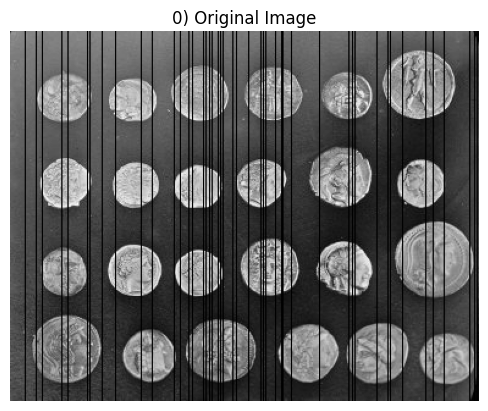

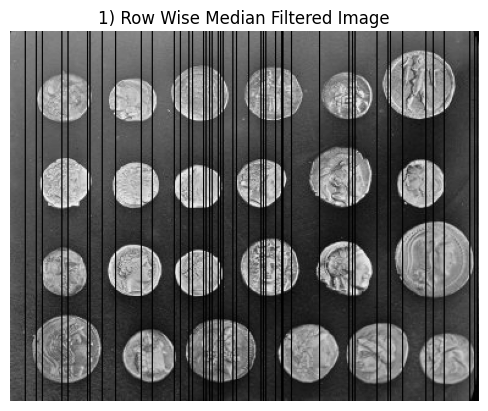

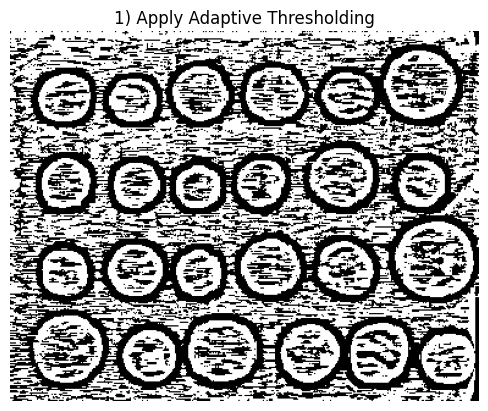

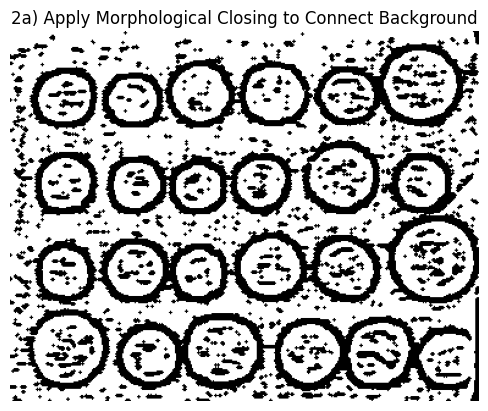

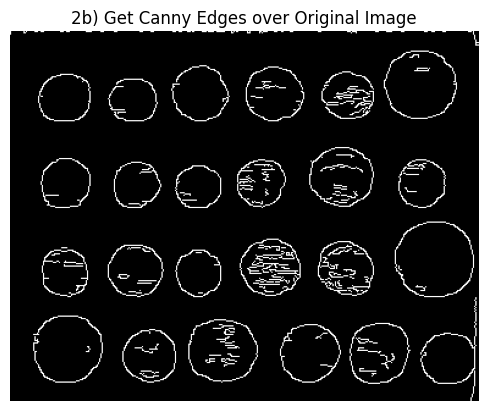

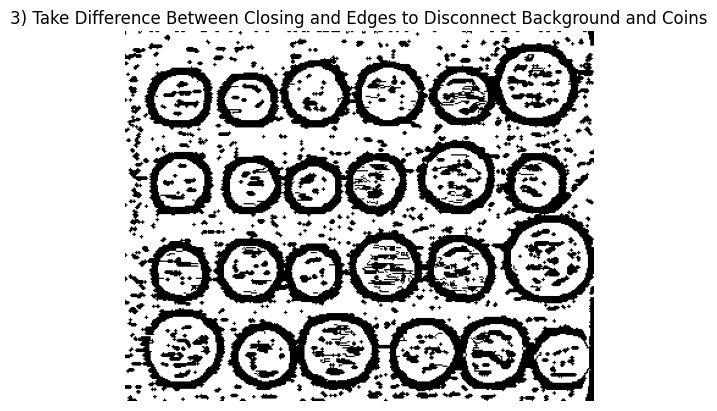

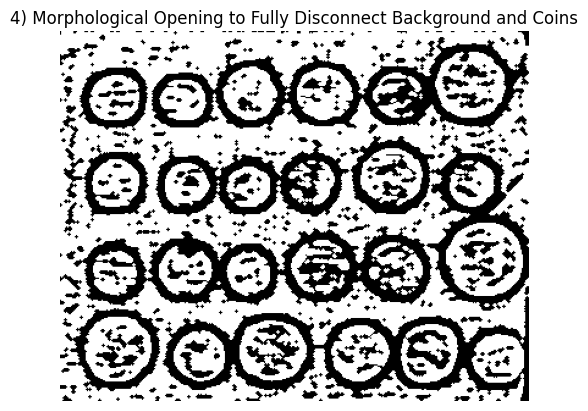

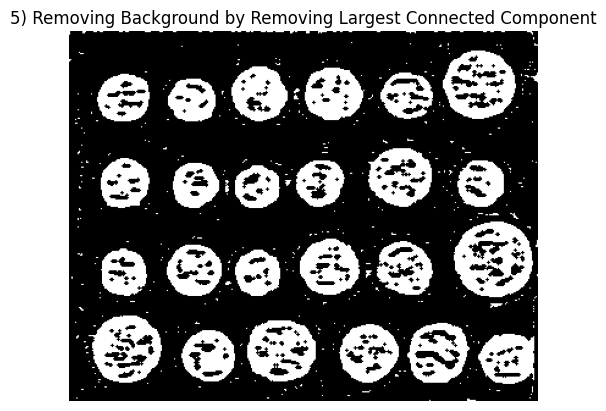

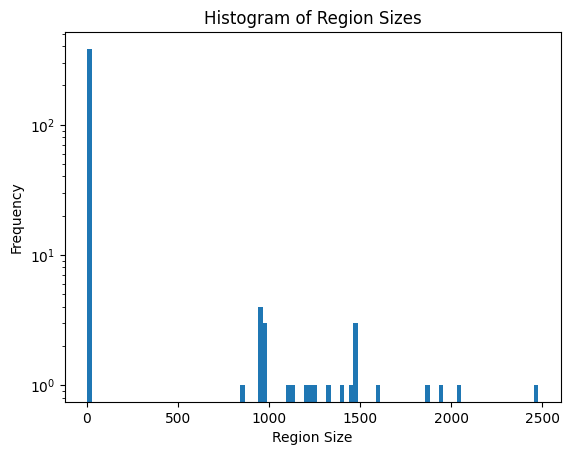

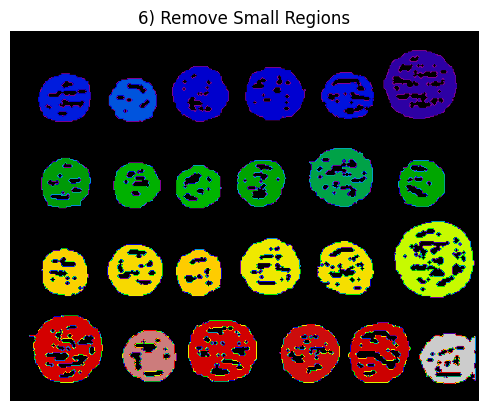

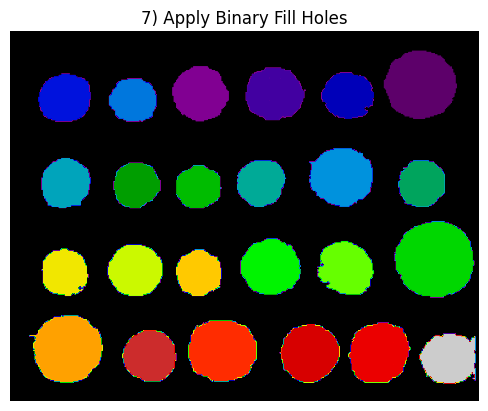

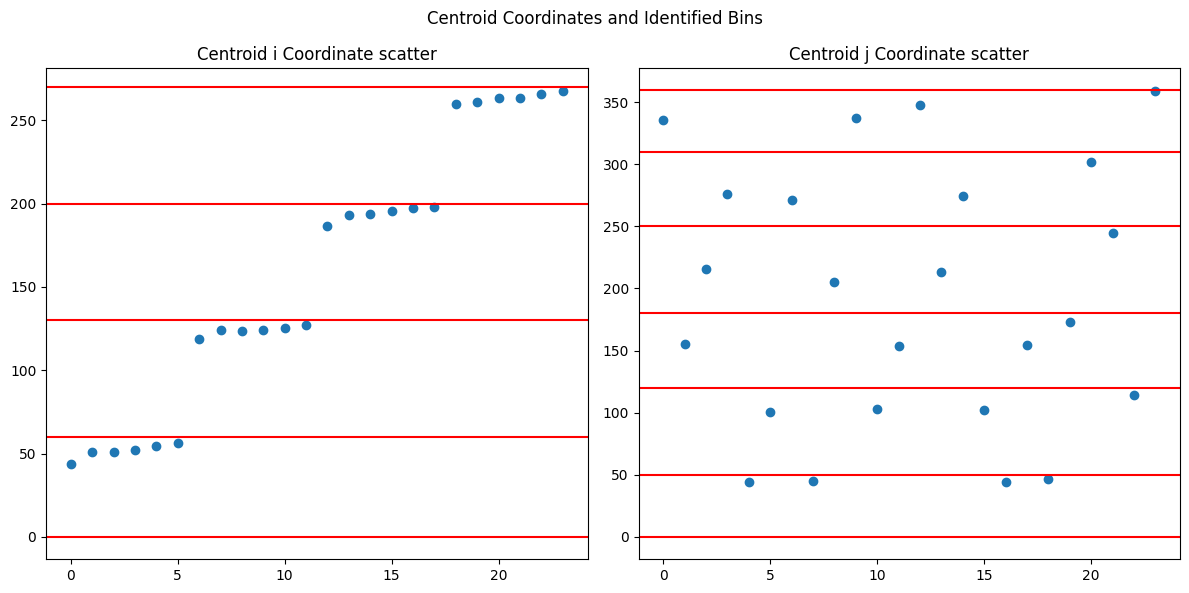

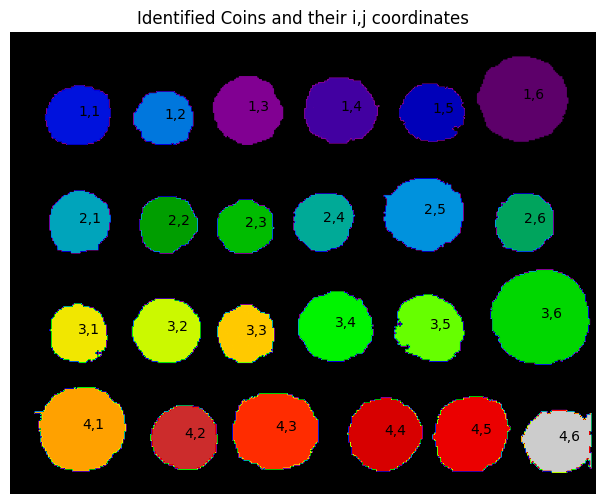

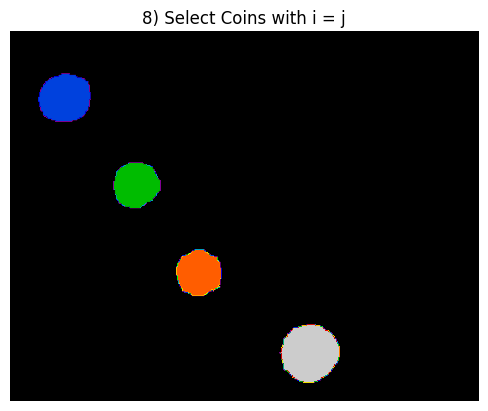

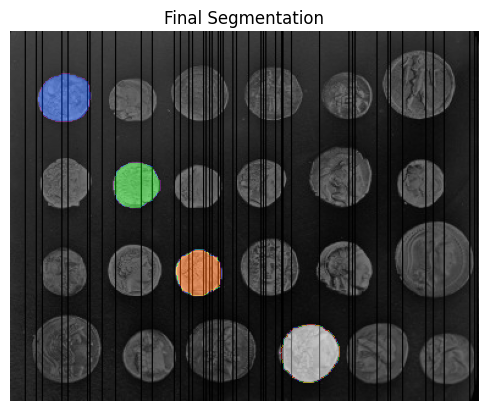

In [4]:
# Load image in grayscale.
image_path = 'data/coins.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Segment all the coins.
coin_mask = segment_coins(image)

# Select the coins where row position = column position.
final_mask = select_coin_segs(coin_mask)

# Overlay the final mask on the original image.
plt.imshow(image, cmap='gray')
plt.imshow(final_mask, cmap='nipy_spectral', alpha=0.5)
plt.title('Final Segmentation')
plt.axis('off')
plt.show()
